# Proyecto Final: Procesamiento de Lenguaje Natural

## Definición del proyecto

El objetivo de este proyecto es utilizar una Red Neuronal Recurrente usando LSTM (Long-Short Term Memory) para hacer traducción de Inglés a Italiano. En los datos de entrenamiento que se nos proporcionan tenemos un par de frases; la frase en inglés y su correspondiente traducción a italiano. 

Para lograr esto, utilizaremos una red "Sequence to Sequence" en el que tendremos dos redes neuronales recurrentes para transformar una secuencia en otra; la primera nos servira como un "Encoder" para transofrmar una entrada de text a un vector mientras que la segunda nos servira para poder

![Red Sequence-Sequence](./imagenes/encoder-decoder.png)

## Requerimientos

Para poder realizar este proyecto decidimos usar PyTorch para poder utilizar tensores y aprovechar el GPU de la computadora para el procesamiento (algo que con numpy no se puede hacer). La versión de Pytorch que utilizamos para este proyecto tiene las siguientes caracteristicas:
 - Version 1.1
 - Windows 10
 - Cuda 10.1
 - Python 3.7
 - Conda

In [1]:
#conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

## Imports

Importamos todas la bibliotecas que vamos a estar utilizando. En este proeycto utilizaremos algunas librerias generales como lo son `string` y `re` que son de uso común durante cualquier proyecto de procesamiento de texto.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

# Cargamos torch
import torch
# Cargamos la biblioteca de redes neuronales de pytorch
import torch.nn as nn
# Biblioteca de optimización de algoritmos
from torch import optim
# Funciones para entrenar la red neuronal.
import torch.nn.functional as F

# Buscamos si el dispositivo donde se ejecuita el algoritmo tiene cuda instalado
# en caso de que no lo tenga usará el CPU para el entrenamiento.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Carga de texto
En este proyecto el proceso de carga de texto se realiza utilizando pares de frases la primera en inglés seguido de un tab y despues en italiano.

```
we therefore respect whatever parliament may decide 	quindi noi rispettiamo le eventuali decisioni in materia del parlamento

```

Como vimos en clase la primera etapa será construir nuestros vectores one hot de las palabras que contiene el corpus de entrenamiento. Para esto generaremos un indice unico para cada una de las palabras el cual utilizará para ubicarse dentro del vector. 

![One Hot](./imagenes/onehot.png)

Lo primero que haremos sera crear todas las funciones para limpiar los datos. Primero, pasamos de Unicode a ASCII y después normalizamos el texto quitando los simbolos especiales.

In [3]:
def unicodeToAscii(w):
    """Transforma la palabra de entrada de Unicode a Ascii 
    basado en https://stackoverflow.com/a/518232/2809427"""
    
    return ''.join(
        c for c in unicodedata.normalize('NFD', w)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeStr(s):
    """Elimina signos de puntuación y transforma el string a minúsculas"""
    
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
MAX_LENGTH = 100

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Desarrollamos una clase llamada Lenguaje, el cual contendrá el las funciones necesarias para pasar de la palabra al indíce y del indice de regreso a la palabra utilizando diccionarios. 

In [5]:
#Defininimos lot tokens de inciio de oracion y de fin de oracion
BOS = 0
EOS = 1

class Language:
    """
    Esta clase sirve para agregar las palabras al diccionario y asignarles un 
    indice. Cuenta con las funciones necesarias tanto para pasar de un indice
    a una palabra como de una palabara a un indice.
    """
    def __init__(self, name):
        """Inicializa las variables locales de la clase que son los diccionarios en los 
        que se almacena la informacion de las palabras"""
        self.name = name
        self.word2index={} # Nos servirá para convertir de una palabra a un índice
        self.word2count={} # Nos servira para contar la frecuencia en que aparece una palabra
        self.index2word={} # Nos servirá para pasar de un índice a una palabra
        self.total = 2     # Noss servirá para contar el total de palabras únicas
        
    def procSentences(self, sentence):
        """Procesa una oración para ser agregada a los diccionarios del lenguaje"""
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        """Agrega las palabras a los diccionarios y actualiza los contadores"""
        if word not in self.word2index:
            self.word2index[word] = self.total
            self.word2count[word] = 1 
            self.index2word[self.total] = word
            self.total += 1
        
        else:
            self.word2count[word] += 1  
        

Hacemos la función que nos permitirá leer las frases que vienen en el archivo de entrenamiento y las almacene.

In [6]:
def readFile(lang1, lang2, reverse=False):
    """Lee el archivo de entrenamiento del traductor, lo limpia y asigna una clase Language
    para almacenar los datos del lenguaje. Se permite revertir el orden para realizar pruebas
    traduciendo de manera inversa el lenguaje.
    """
    
    print("Loading Files...")

    # Abrimos el archivo y lo dividmos por salto de linea para obtener
    # los pares en una sola linea.
    lines = open('./corpus/data3.test', encoding='utf-8').read().strip().split('\n')
    #print("Found {} lines".format(len(lines)))

    # Dividimos los pares en una linea en su lenguaje de entrada y lenguaje de salida
    pairs = [[normalizeStr(s) for s in l.split('\t')] for l in lines]

    # Instanceamos las clases Lang
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Language(lang2)
        output_lang = Language(lang1)
    else:
        input_lang = Language(lang1)
        output_lang = Language(lang2)

    return input_lang, output_lang, pairs

Cargamos los datos del set de entrenamieto a dos clases de tipo Language: input(inglés) y output(italiano). 

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readFile(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.procSentences(pair[0])
        output_lang.procSentences(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.total)
    print(output_lang.name, output_lang.total)
    return output_lang, input_lang, pairs


output_lang, input_lang, pairs = prepareData('eng', 'ita', False)
print(random.choice(pairs))

Loading Files...
Read 900 sentence pairs
Trimmed to 897 sentence pairs
Counting words...
Counted words:
eng 3276
ita 4389
['the vote will take place tomorrow at pm', 'la votazione si svolgera domani alle']


In [8]:
input_lang

## Red Neuronal Recurrente (RNN)
Una red neuronal recurrente es un tipo de red que utiliza secuancias para preoducir una salida tomando en cuenta la organización de la entrada de la red. Uno de los principales retos con las RNN es que el modelo de la red normalmente produce como máximo una salida por cada dato de entrada y en el ejemplo de traducción tenemos palabras que pueden producir más de una salida por lo que el modelo tradicional de RNN no nos es completamente útil para traducción.

### Seq2Seq (Encoder-Decoder)
Para solucionar esto, utilizaremos dos RNR una que nos servirá de encoder y otra que nos servirá de decoder de la traducción. El objetivo con esto es que sin importar la longitud de la frase de entrada o su organización, en cuanto a la posición de las palabras en el texto, podamos hacer la traducción de la manera más precisa posible. Esto se logra generando un vector intermedio en el que se intenta almacenar el significado de la frase de entrada a través del encoder y despues este significado es interpretado por el decoder en la salida.

![encoder-decoder](./imagenes/paper-encode.png)

Al final, viendo la imagen #1 del Notebook, no importa si la entrada es `le chat es noir` o `le chat noir` como el significado es el mismo debería producir el mismo resultado.

### Encoder

Un encoder de una red seq2seq utiliza el la secuanciaq de datos de entrada para generar un estado oculto el cual se va actualizando y se utriliza para el siguiente dato de entrada.

Para el encoder usaremos una unidad GRU (Unidad Recurrente multicapa con compuertas), la cual, para cada una de las entradas, hará el siguiente cálculo.

\begin{array}{ll}
            r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
            z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
            n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
            h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
\end{array}

Donde:
\begin{array}{ll}
     h_{(t)} -> \text{Estado oculto en el tiempo t}\\
     x_t -> \text{La entrada en el tiempo t} \\
     h_{(t-1)} -> \text{Estado oculto en el tiempo t-1 o el inicial para t=0} \\
     z_t -> \text{Gate de actualización} \\
     r_t -> \text{Gate de reset} \\
     n_t -> \text{}\\
     \sigma -> \text{Funcion sigmoide} \\
     * -> \text{Producto de Hadamard} \\
\end{array}
        

In [9]:
class Encoder(nn.Module):
    """Clase encoder que toma un vector de entrada y lo embede para aplicar la unidad 
    recurrente y terminar generando un vector de salida y un vector de capa oculta"""
    def __init__(self, input_size, hidden_size):
        """Inicicaliza el encode con el tamaño que asignemos para el vector de la capa oculta"""
        
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        """Programamos el forward para obtener el output y el hidden vector"""
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        """Inicializa el vector de la capa oculta con ceros"""
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decodificador
En este caso vamos a hacer que el decosder tome dos parte del encoder: el vector de salida que generó el encoder al cual le llamaremos el vector de contexto que se utilizará como la inicialización de la capa oculta en el decodificador.

Los paso del decodificador serán los siguientes:
 1. Embedding del input
 2. Aplicamos RELU al embedding
 3. Aplicamos la unidad GRU y obtenemos un output y una capa oculta
 4. al output aplicamos un softmax 
 
Recordando que:
 
 $\text{ReLu} -> f(x)=max(0, x)$
 
 $\text{Linear}-> y = xA^T + b$
 
 $\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$

In [10]:
class Decoder(nn.Module):
    """Esta clase aimplementa un decoder sencillo que utiliza un vector de contexto y un 
    vector de entrada que provienen del encoder."""
    
    def __init__(self, hidden_size, output_size):
        """Inicializamos la capa oculta del decodificador y las funciones como 
        parte del decoder."""
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        """Hacemos el forward de la neurona con los pasos explicados previamente"""
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        """Inicializamos el vector de la capa oculta con ceros."""
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decodificador con Atención
Un problema que tiene el modelo anterior es que considera el mismo peso para todas las entradas del vector de contexto por lo que si damos pesos distintos a cada uno de las casillas de los vectores dependiendo de su relevancia en la frase podremos obtener una optimización al momento de traducir ya que el decodificador podrá enfocarse únicamente en una parte del vector de contexto. A esto se le llama `aplicacion de atención`. 

Para hacer el calculo de atención es necesario agregar una red feedforward adicional que tome las salida del encoder, se le aplique softmax al vector salida de la red y con eso obtendremos los pesos de cada uno de los bloques del vector de atención. La arquitectura de la red queda como se muestra a continuación: 

![arquitectura](./imagenes/atention.png)

In [11]:
class AttnDecoder(nn.Module):
    """Decodificador utilizando una red neuronal recursive con atención."""
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """Inicializamos el decodificador basandonos en la arquitectura anterior"""
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size # Tamaño de la capa oculta
        self.output_size = output_size # Tamaño del vector de salida
        self.dropout_p = dropout_p     # Valor del dropout
        self.max_length = max_length   # Tamaño máximo de la frase que se va a leer

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)     # Función para hacer el embedding
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)          # Activación Lineal
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size) # Vector que une el peso y atencion aplicada 
        self.dropout = nn.Dropout(self.dropout_p)                             # Aplicación de Bernouli para eliminar elementos
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        """Fase forward del Decoder.Bloques azules de la arquitectura"""
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0)) # Union de los vecotres encoder y attn weights

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        """Inicializa el decodificador"""
        return torch.zeros(1, 1, self.hidden_size, device=device)

Preparamos los datos para ser usado en la fase de entrenamiento.

In [12]:
def indexesFromSentence(lang, sentence):
    """Obtiene los indices dependiendo de la palabra"""
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    """Convertimos una oración en un tensor"""
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    """Convierte el Par de frases en Tensores"""
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Entrenamiento

Para el entrenamiento de la red, debemos hacer que la red recuerde o tenga presente los resultados anteriores en y el estado de la capa oculta. Despues se le daba dar al decodificador una etiqueta de inicio de oración y la utilizará como el primer dato de entrada de la red. 

El concepto de `teacher_forcing_ratio` es el concepto de utilizar las salidas de target reales como cada entrada siguiente, en lugar de utilizarel decodificador como la siguiente entrada. Usar el `teacher_forcing_ratio` hace que converja más rápido hacia la solución.

In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    """Funcion que nos da la base del entrenamiento del algoritmo"""

    encoder_optimizer.zero_grad() # Limpia los gradiantes.
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Agregamos el token de BOS en el incio del tensor del decodificador
    decoder_input = torch.tensor([[BOS]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Usamos teacher forcing para usar el target en el entrenamiento
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Sin el teacher forcing usamos las predicciones como input en el entrenamiento. 
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            
            # Si llega a EOS termina el ciclo
            if decoder_input.item() == EOS:
                break

    loss.backward() # Calculamos BackPropagation

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

### Funciones de apoyo
Creamos una serie de funciones de apoyo para que podamos medir tiempos d entrenamiento.

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    """Corre la fase de entrenamiento en un determinado número de iteraciones e imprime
    los tiempos necesarios así como el loss que tiene el entrenamiento. Cuenta con los siguientes procesos:
    
        1) Comienza con el timer para calcular el tiempo de entrenamiento.
        2) Inicializa los oprtimizadores y criterion
        3) Crea los pares de entrenamiento
        4) Crea los vectores de las graficas
    """
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Para optimizar el encoder y decoder usamos Stochastic Gradient Descent (SGD)
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    # Para obtener el criterion usamos negative log likelihood loss (NLLLoss)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [16]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    """Imprimimos ls gráfica"""
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Probar el Modelo
Para probar el modelo seguimso un procedimiento similar al de entrenamietno pero en esta ocasión no le enviamos los targets al decodificador pero si lo alimentamos con las probabilidades que va obteniendo. Cuadno la probabilidad de EOS es muy alta es cuando el decodificador se detiene.

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[BOS]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Usamos el metodo anterior para poder evaluar las frases y mostrar la frase original, el target y, por último, el output de la red seq2seq. Esto nos sirve para hacer la comparación entre lo que esperamos de resultado y lo que obtenemos.

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Entrenamos el modelo
Para entrenar el modelo, hicimos varias pruebas de sobre el numero de iteraciones óptimo ya que si entrenabamos con demasiadas iteraciones el "loss" aumentaba al final o si usabamos muy poco 

2m 30s (- 47m 31s) (1000 5%) 5.3746
4m 53s (- 44m 3s) (2000 10%) 5.1583
7m 14s (- 41m 0s) (3000 15%) 4.9700
9m 40s (- 38m 41s) (4000 20%) 4.7750
12m 4s (- 36m 13s) (5000 25%) 4.5432
14m 31s (- 33m 54s) (6000 30%) 4.3629
16m 58s (- 31m 32s) (7000 35%) 4.1569
19m 30s (- 29m 15s) (8000 40%) 3.9300
21m 59s (- 26m 53s) (9000 45%) 3.6441
24m 29s (- 24m 29s) (10000 50%) 3.5987
27m 6s (- 22m 10s) (11000 55%) 3.2824
29m 39s (- 19m 46s) (12000 60%) 3.1099
32m 22s (- 17m 26s) (13000 65%) 2.9756
35m 0s (- 15m 0s) (14000 70%) 2.8072
37m 42s (- 12m 34s) (15000 75%) 2.8006
40m 18s (- 10m 4s) (16000 80%) 2.6489
43m 1s (- 7m 35s) (17000 85%) 2.7290
45m 38s (- 5m 4s) (18000 90%) 2.5496
48m 18s (- 2m 32s) (19000 95%) 2.6260
50m 58s (- 0m 0s) (20000 100%) 2.5824


<Figure size 432x288 with 0 Axes>

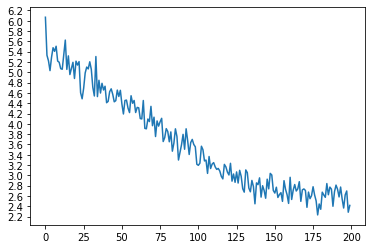

In [19]:
hidden_size = 256
encoder1 = Encoder(input_lang.total, hidden_size).to(device)
attn_decoder1 = AttnDecoder(hidden_size, output_lang.total, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 20000, print_every=1000)

# Probar el Modelo
Evaluamos el modelo con datos aleatorios para comparar la salida esperada y la salida obtenida de manera visual. Esto nos permite darnos una idea de que tan buena es la traducción que hace el sistema.

In [29]:
evaluateRandomly(encoder1, attn_decoder1)

> however when it comes to safety i am rather sceptical because safety in sweden for example is in principle no different from safety in germany italy or austria
= per quanto riguarda la sicurezza invece sono piuttosto scettico in quanto la sicurezza in svezia non e sostanzialmente diversa dalla sicurezza in germania in italia o in austria
< per quanto riguarda la la la quanto la sicurezza in quanto in in quanto in quanto in in quanto in in in quanto in la quanto in in in in in in in in in in in in in in in quanto in in in in dalla <EOS>

> you will tell me that situations of growth or shortage do not affect everyone alike i agree with your analysis
= mi ribatterete che la crescita o la penuria non valgono per tutti e sono pienamente d accordo con tali analisi
< mi ribatterete che la crescita che non la la per valgono e la pienamente d accordo con il parlamento <EOS>

> these days someone who lives in an old people s home is accommodated within the social field
= oggi come oggi chi ris

In [112]:
import difflib
evaluations = 300

def evalTranslator():
    correctos = 0.0
    for i in range(evaluations):
        pair = random.choice(pairs)
        tradGen, att = evaluate(encoder1, attn_decoder1, pair[0])
        correctos += difflib.SequenceMatcher(lambda x: x == " ", trad,tradG[:-6]).ratio()
    acc = correctos / evaluations
    return acc
                                
accuracy = evalTranslator()
print(accuracy)

0.9090909090909086


In [35]:
def readTestsFile(lang):
    """Lee el archivo de entrenamiento del traductor, lo limpia y asigna una clase Language
    para almacenar los datos del lenguaje. Se permite revertir el orden para realizar pruebas
    traduciendo de manera inversa el lenguaje.
    """
    
    print("Loading Evaluation...")

    # Abrimos el archivo y lo dividmos por salto de linea para obtener
    # los pares en una sola linea.
    lines = []
    lines = open('./corpus/data3.eval', encoding='utf-8').read().strip().split('\n')
    #print("Found {} lines".format(len(lines)))
    return lines


eval_sentence = readTestsFile('eng')
print(random.choice(eval_sentence))

Loading Files...
given that the commission is represented by vicepresident de palacio i believe that before voting it would help if the commission could let us know how ready it is to present this programme as agreed alternatively parliament is not ready to examine this programme as some appear to be suggesting


In [84]:
sentence = random.choice(eval_sentence)
print('>', sentence)
output_words, attentions = evaluate(encoder1, attn_decoder1, sentence)
output_sentence = ' '.join(output_words)
print('<', output_sentence)
print('')


> agenda
< per la proposta di la punto di vista del giorno <EOS>



## Referencias
 
 - Basile, Pierpaolo, et al. “Bi-Directional LSTM-CNNs-CRF for Italian Sequence Labeling.” Proceedings of the Fourth Italian Conference on Computational Linguistics CLiC-It 2017, 2017, pp. 18–23., doi:10.4000/books.aaccademia.2339.
 - Raval, Siraj. “Recurrent Neural Network - The Math of Intelligence (Week 5).” YouTube, YouTube, 19 July 2017, www.youtube.com/watch?v=BwmddtPFWtA.
 - Raval, Siraj. “LSTM Networks - The Math of Intelligence (Week 8).” YouTube, YouTube, 9 Aug. 2017, www.youtube.com/watch?v=9zhrxE5PQgY. 
 - Trask, Andrew. “Anyone Can Learn To Code an LSTM-RNN in Python (Part 1: RNN).” Anyone Can Learn To Code an LSTM-RNN in Python (Part 1: RNN) - i Am Trask, iamtrask.github.io/2015/11/15/anyone-can-code-lstm/.
 - PyTorch. “Translation with a Sequence to Sequence Network and Attention.” Translation with a Sequence to Sequence Network and Attention - PyTorch Tutorials 1.1.0 Documentation, pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.
 - Ilya Sutskever. “Sequence to Sequence Learning with Neural Networks.” Cornell University, 10 Sept. 2014, arxiv.org/abs/1409.3215v3.
 - Cho, Kyunghyun, et al. “Learning Phrase Representations Using RNN Encoder–Decoder for Statistical Machine Translation.” Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), 3 Sept. 2014, doi:10.3115/v1/d14-1179.
 - Luong, Thang, et al. “Effective Approaches to Attention-Based Neural Machine Translation.” Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing, 2015, doi:10.18653/v1/d15-1166.


